In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


2024-08-07 08:20:29.222101: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 08:20:29.222248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 08:20:29.407738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6144 - loss: 0.6385 - val_accuracy: 0.7889 - val_loss: 0.4754
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7860 - loss: 0.5068 - val_accuracy: 0.8333 - val_loss: 0.3943
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8219 - loss: 0.4305 - val_accuracy: 0.8444 - val_loss: 0.4025
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8017 - loss: 0.4540 - val_accuracy: 0.8556 - val_loss: 0.3935
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8079 - loss: 0.4307 - val_accuracy: 0.8444 - val_loss: 0.4459
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8127 - loss: 0.4296 - val_accuracy: 0.8333 - val_loss: 0.4290
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8161 - loss: 0.4285 - val_accuracy: 0.8333 - val_loss: 0.4202
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8224 - loss: 0.4142 - val_accuracy: 0.8556 - val_loss

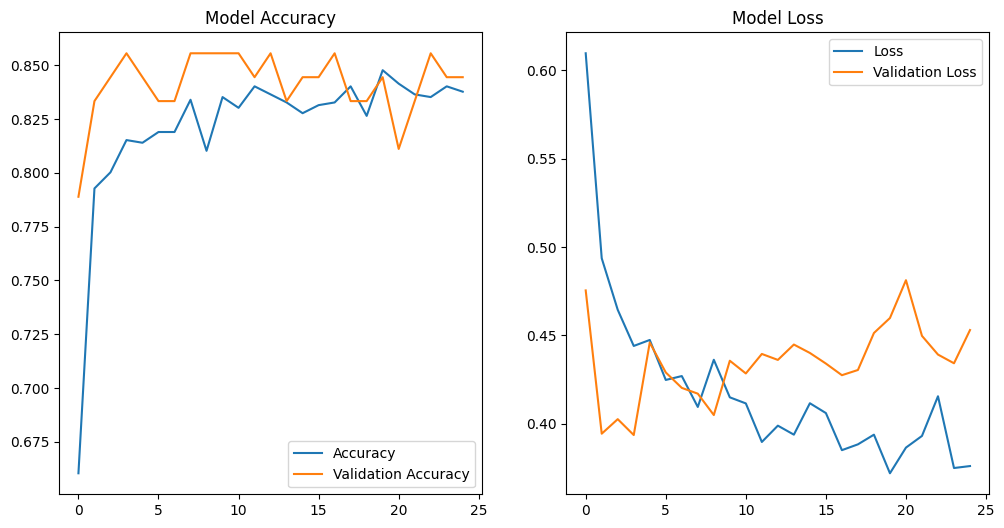

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Submission file created.


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

test_data_passenger_ids = test_data['PassengerId']

train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch']
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch']
train_data['IsAlone'] = (train_data['FamilySize'] == 0).astype(int)
test_data['IsAlone'] = (test_data['FamilySize'] == 0).astype(int)

imputer_age = SimpleImputer(strategy='median')
imputer_fare = SimpleImputer(strategy='median')

train_data['Age'] = imputer_age.fit_transform(train_data[['Age']])
train_data['Fare'] = imputer_fare.fit_transform(train_data[['Fare']])
test_data['Age'] = imputer_age.transform(test_data[['Age']])
test_data['Fare'] = imputer_fare.transform(test_data[['Fare']])

drop_columns = ['Name', 'Ticket', 'Cabin', 'PassengerId']
train_data = train_data.drop(columns=drop_columns)
test_data = test_data.drop(columns=drop_columns)

X = train_data.drop('Survived', axis=1)
y = train_data['Survived']
X_test = test_data.copy()

# pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['Age', 'Fare', 'FamilySize', 'SibSp', 'Parch', 'IsAlone']),
        ('cat', Pipeline(steps=[
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), ['Pclass', 'Sex', 'Embarked'])
    ]
)

# model split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

# constuct model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(preprocessor.fit_transform(X_train).shape[1],)),  # Правильное использование Input
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

def fit_model(X_train, y_train, X_valid, y_valid):
    preprocessed_X_train = preprocessor.fit_transform(X_train)
    preprocessed_X_valid = preprocessor.transform(X_valid)
    history = model.fit(
        preprocessed_X_train, y_train,
        validation_data=(preprocessed_X_valid, y_valid),
        epochs=25, verbose=1, batch_size=32
    )
    return history

# learning
history = fit_model(X_train, y_train, X_valid, y_valid)

#Visualizing
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

preprocessed_X_test = preprocessor.transform(X_test)
predictions = model.predict(preprocessed_X_test)
predictions = (predictions > 0.5).astype(int)

# final DF for submission
submission = pd.DataFrame({
    'PassengerId': test_data_passenger_ids,
    'Survived': predictions.flatten().astype(int)
})

submission.to_csv('/kaggle/working/submission.csv', index=False)

print('Submission file created.')
